# Question Three

**Fit a linear model to the log-death series as a function of time during the exponentially increasing phase of the epidemic to estimate r. Choose a subset of data that seems reasonable to you for this fit. Make sure to include the units of r in your answer! What is the doubling time implied by your estimate?**

Doubles every: 1.3391632017843782


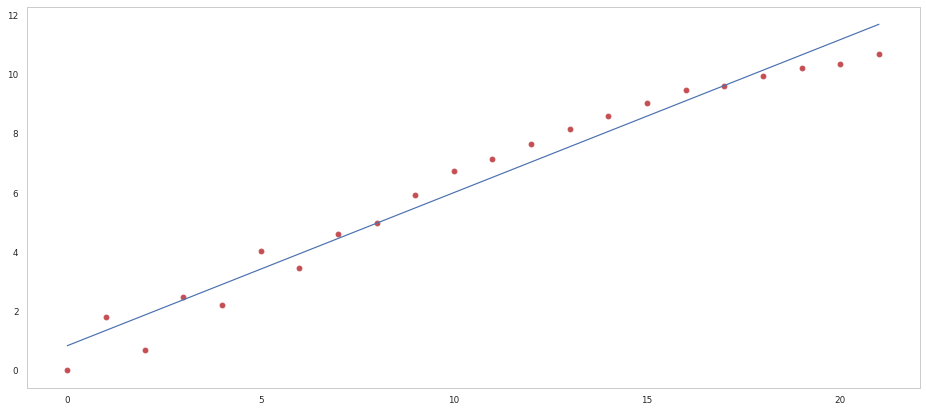

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18}
sns.set(rc=rc)
sns.set_style("whitegrid", {'axes.grid' : False}) #remove grey grid
sns.set_context("paper") #changes the theme or the size or something ... not sure why I added this. 
plt.rcParams['figure.figsize'] = [16, 7] #changes the size


plague = pd.read_csv("great_plague.csv") #read in data
plague['log deaths'] = np.log(plague['plague_deaths']) #add log deaths column to datafram



cutoff = 21 #what week do we analyze up to?
X = plague.iloc[:cutoff+1, 1].values.reshape(-1, 1)   #Get weeks column
Y = plague.iloc[:cutoff+1, 3].values.reshape(-1, 1)   #Get log-deaths column
model = LinearRegression()   #Instantiate object from class
model.fit(X, Y)   #Fit model
Y_pred = model.predict(X)   #Get trendline
plt.plot(Y, 'ro') #plot data
plt.plot(Y_pred)  #plot trendline



r  = model.coef_[0][0] #r = growth coefficient 


#Doubles every () weeks
print("Doubles every:",np.log(2) / r)

Implied doubling time is given by the output above.

**B) The generation time/infectious period for plague is approximately 2.5 weeks. Combine this information with your r estimate to get a rough estimate of contact rate $\beta$, removal rate $\gamma$, and $R_0$ for plague in London in 1665.**

In [39]:
k = 2.5
gamma = 1/k
beta = r + gamma
R0 = beta/gamma

print("Gamma:", gamma)
print("Beta:", beta )
print("R0:", R0)

Gamma: 0.4
Beta: 0.9175972425439678
R0: 2.2939931063599195


**The case fatality rate for plague (let’s call it $\Phi$) was about 40% in the 17th century; the population of London was about 130,000. Using the following crude assumptions:**

*$\phi$, the death rate, is 0.4*, and the population is 130000 people.

In [40]:
phi = 0.4
N = 130000
dt = 1 

*parameterize the incidence term in your model as $\beta$/NSI, set initial conditions:*

In [41]:
S0 =N
I0 = (phi*beta)/ (N*S0)
y0 = [N,1/(phi*beta),0]

def SIRode(y,t, beta, gamma):
    S,I,R = y[0],y[1],y[2]
    dydt = [ (-beta/N*(N-(I))*(I)) , beta/N*(N-(I))*(I) - gamma*I, gamma*I ]
    return dydt

**Numerically solve the ODE for your initial guess. Plot the time series of deaths and superimpose the curve of $\phi \frac{\beta}{NSI}$ from your solution. Do not expect them to match exactly; the point of all the work above was to get a solution that was at least on the right order of magnitude.d fitting**

Plotting predicted deaths vs realized deaths

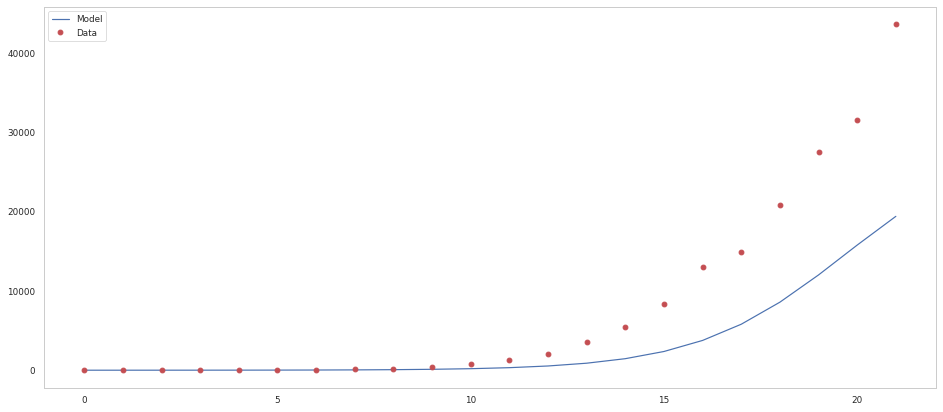

In [42]:
###Test###
t = np.arange(0,cutoff + dt, dt )
sol = odeint(SIRode, y0, t, args = (beta,gamma))
plt.plot(t,phi*sol[:,1], label = "Model")
plt.plot(plague['plague_deaths'][:cutoff+1], 'ro',label = "Data");
plt.legend(loc='best');

**Adjust the values:** 

It undershots because we estimated $r$ from the log linear model on deaths — estimated from only deaths with no fractional scalar representing mortaility rate — and so we predict fit on deaths, predict cases from deaths without changing any numbers, and then multiply cases by $\phi = 0.4$. This was what was asked of us, but it will undershoot every single time. Increasing our estimate of $r$ to account for this, a second guess is:

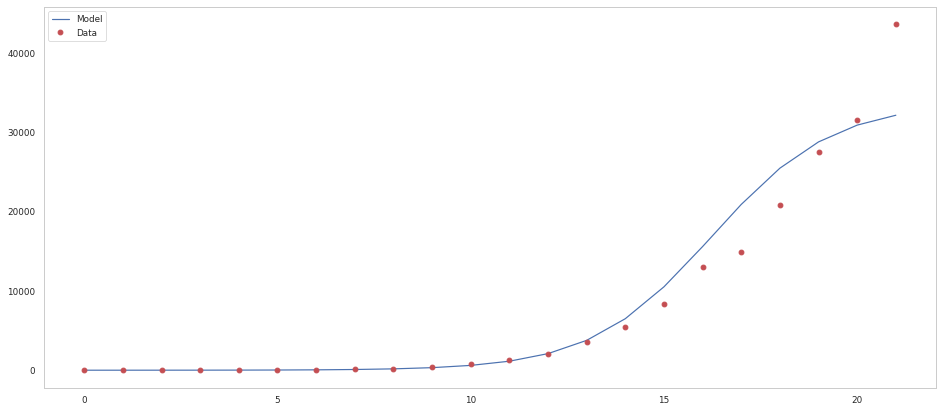

In [43]:
###PARAMS###
N = 130000
k = 2.5
gamma = 0.35
beta = 0.99175972425439678

R0 = beta/gamma
y0 = [N,1/(0.4*beta),0]
dt = 1


###Test###
t = np.arange(0,cutoff + dt, dt )
sol = odeint(SIRode, y0, t, args = (beta,gamma))
plt.plot(t,phi*sol[:,1], label = "Model")
plt.plot(plague['plague_deaths'][:cutoff+1], 'ro',label = "Data")
plt.legend(loc='best')

Starting the model `lag` days late and again increasing $r$:

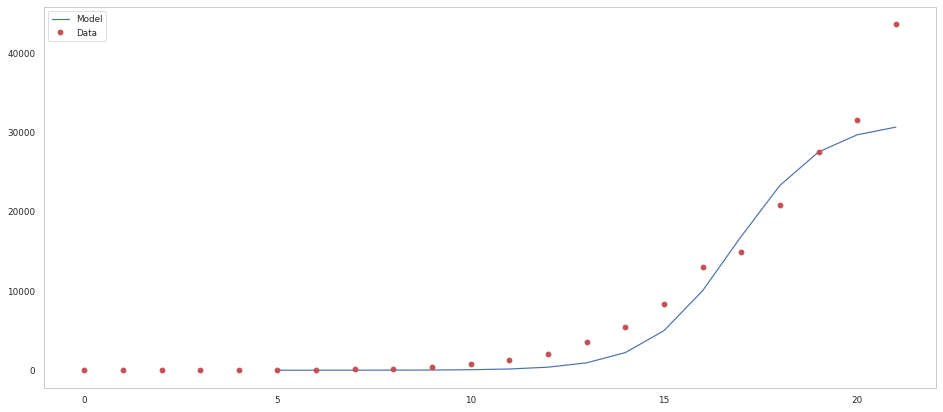

In [44]:
###PARAMS###
N = 130000
k = 2.5
gamma = 0.6
beta = 1.5099175972425439678

R0 = beta/gamma
y0 = [N,1/(0.4*beta),0]
dt = 1


###Test###
lag = 5
t = np.arange(lag,cutoff  + dt, dt )
sol = odeint(SIRode, y0, t, args = (beta,gamma))
plt.plot(t,phi*sol[:,1], label = "Model")
plt.plot(plague['plague_deaths'][:cutoff+1], 'ro',label = "Data")
plt.legend(loc='best')

Switching instead to match fit on deaths and recover cases by multiplying by $2-\phi$, removing time lag:

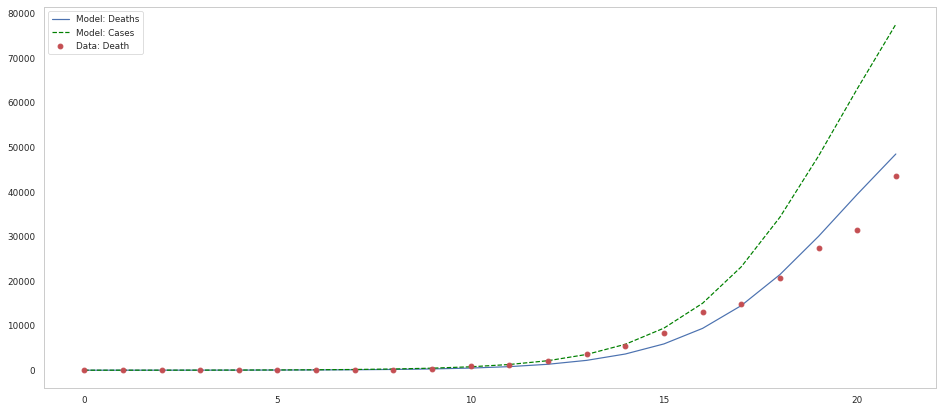

In [45]:
###PARAMS###
N = 130000
k = 2.5
gamma = 0.4
beta =  0.9175972425439678

R0 = beta/gamma
y0 = [N,1/(0.4*beta),0]
dt = 1


###Test###
lag = 0
t = np.arange(0,cutoff  + dt, dt )
sol = odeint(SIRode, y0, t, args = (beta,gamma))
plt.plot(t,sol[:,1], label = "Model: Deaths")
plt.plot(t,(2-phi)*sol[:,1],'--', label = "Model: Cases", color = "green")

plt.plot(plague['plague_deaths'][:cutoff+1], 'ro',label = "Data: Death")
plt.legend(loc='best')

Build a very simple optimizer to look over the space of parameters close to our choices, and to choose the ones that minimize MSE.

In [46]:
#Simple Optimizer
Iter = 100

bestBeta = beta
bestGamma = gamma
betaInit = beta
gammaInit = gamma
mintolBeta = -0.1
maxtolBeta =  0.1
mintolGamma = - 0.1
maxtolGamma = 0.1
mseArr = []
TotalArray = []
MSEInit = mean_squared_error(np.array(plague['plague_deaths'][lag:cutoff+1]),sol[:,1])

for i in range(0,Iter):
    for j in range(0,Iter):

        beta  = betaInit  * (1+np.random.uniform(mintolBeta,maxtolBeta,1)[0])
        gamma = gammaInit * (1+np.random.uniform(mintolGamma,maxtolGamma,1)[0])
        
        y0 = [N,1/(0.4*beta),0]
        
        sol = odeint(SIRode, y0, t, args = (beta,gamma))
        MSE = mean_squared_error(np.array(plague['plague_deaths'][lag:cutoff+1]),phi*sol[:,1])
        TotalArray.append([beta, gamma, MSE])
        
        mseArr.append(MSEInit)
        
        if MSE < MSEInit:
            MSEInit = MSE
            bestBeta = beta
            bestGamma = gamma

Is there a pattern we can use to quickly build a better optimizer? Looking at the MSE over the space of possible parameter combinations for Beta(x-axis) and Gamma(y-axis) that stay close enough that they don't totally lose our $r$ value. 

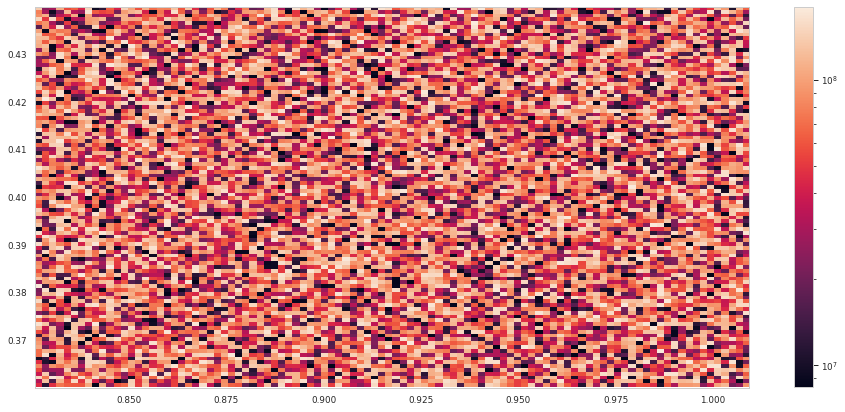

In [47]:
arr = np.array(TotalArray).T 
zl = arr[2]
yl = arr[1]
xl = arr[0]

N = int(len(zl)**.5)
z = zl.reshape(N, N)
plt.imshow(z, extent=(np.amin(xl), np.amax(xl), np.amin(yl), np.amax(yl)), norm=LogNorm(), aspect = 'auto')
plt.colorbar()
plt.show()

There isn't, so we'll stick with the parameters recovered here. Modelling it, we see:

0.9175972425439678
0.4


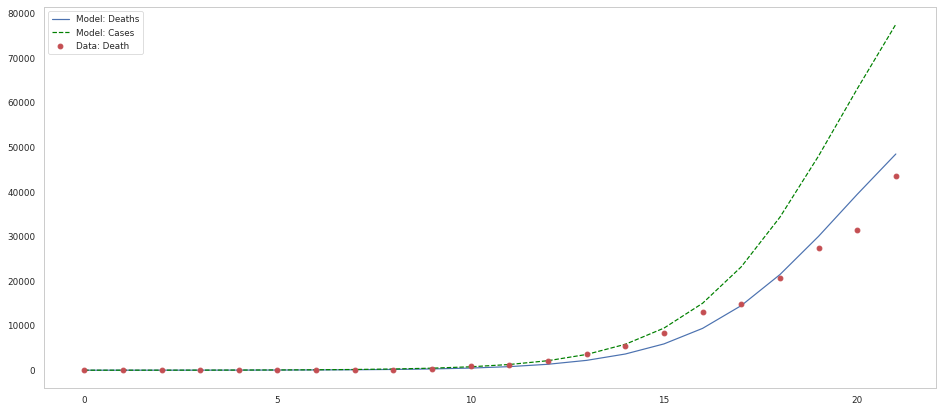

In [48]:
###PARAMS###
N = 130000
k = 2.5
gamma = bestGamma
beta = bestBeta
R0 = beta/gamma
y0 = [N,1/(0.4*beta),0]
dt = 1


###Test###
lag = 0
t = np.arange(0,cutoff  + dt, dt )
sol = odeint(SIRode, y0, t, args = (beta,gamma))
q = (2-phi)*sol[:,1]
plt.plot(t,sol[:,1], label = "Model: Deaths")
plt.plot(t,(2-phi)*sol[:,1],'--', label = "Model: Cases", color = "green")

plt.plot(plague['plague_deaths'][:cutoff+1], 'ro',label = "Data: Death")
plt.legend(loc='best')


#Predict
print(bestBeta)
print(bestGamma)

Model with final parameters:

Gamma: 0.4
Beta: 0.9175972425439678
R0: 2.2939931063599195
r: 0.5175972425439678


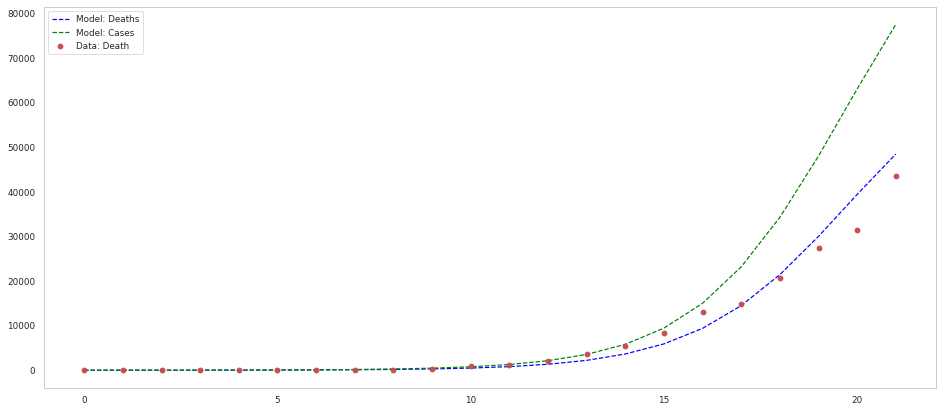

In [49]:
###PARAMS###
N = 130000
k = 2.5
y0 = [N,1/(0.4*beta),0]
dt = 1


###Test###
lag = 0
t = np.arange(0,cutoff  + dt, dt )
sol = odeint(SIRode, y0, t, args = (beta,gamma))
#plt.plot(t,sol[:,1], label = "Model: Deaths")
plt.plot(t,sol[:,1],'--', label = "Model: Deaths", color = "Blue")
plt.plot(t,(2-phi)*sol[:,1],'--', label = "Model: Cases", color = "green")


plt.plot(plague['plague_deaths'][:cutoff+1], 'ro',label = "Data: Death")
plt.legend(loc='best')


#Parameters
print("Gamma:", gamma)
print("Beta:", beta )
print("R0:", R0)
print("r:", r)